In [50]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from scipy.signal import find_peaks_cwt
%matplotlib inline

In [64]:
#set starting values for parameters that should be constant across the peaks i.e. the peak shapes
#Shape of the peak defined by the width sigma, tail height r, and tail decay constant beta.
sig = 4.
r = 15.
beta = 15.

#default bounds for A and mu
#A can't be less than 0 (yay the upside down peaks that you sometimes get in gf3 are no more)
#mu unbounded - can be anywhere on the spectrum
bnd = ((0.,None), (None,None), )
#bounds for metaparameters sigma, r, and beta (they are 'meta' because they should remain constant across peaks locally)
#set sigma bound at the resolution of the detector - it's about 4 channels for Munich using the binning that I am
#This can change though. I've set the upper bound to 10 channels just so it doesn't try to fit the background
#It can't be negative either
#R can only be between 0 and 100 since it's a percentage of the height
#Beta can be any positive number
metabnd = ((0.1,10), (0.1, 100), (0.1,None))

In [65]:
#Define gf3 function
def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

#define log likelihood, the thing we want to maximise
def lnlike(p0, x, y):
    
    # get model for these parameters:
    npeaks = int((len(p0)-3)/2)
    ymod = 0
    for i in range(npeaks):
        p1 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
        ymod += gf3(p1,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(y!=0)]*np.log(y[np.where(y!=0)])) - np.sum(y) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

def amp(mu, x, y):
    print(y)
    return np.max(y[int(np.where(x == mu + 0.5)[0]) - sig : int(np.where(x == mu + 0.5)[0]) + sig ])

In [66]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals2=[];ymeas2=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals2.append(float(items[0]))
    ymeas2.append(float(items[1]))

infile.close()

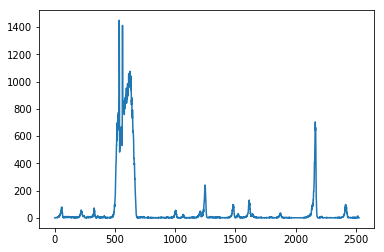

In [67]:
ymeas2[0] = 0
pl.plot(xvals2,ymeas2)
pl.show()

#Object Detection

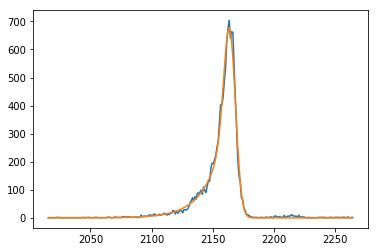

In [68]:
#Acquire Template
xtemp = np.array(xvals2[1800:2000])
ytemp = np.array(ymeas2[1800:2000])
pl.plot(xtemp,ytemp)


mutemp = xtemp[np.argmax(ytemp)]
Atemp = np.max(ytemp)


ptemp0 = [Atemp, mutemp, sig, r, beta]
bndstemp = (bnd[0], bnd[1], metabnd[0], metabnd[1], metabnd[2])

nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, ptemp0, bounds=bndstemp, args=(xtemp, ytemp))
ptemp1 = result["x"]

ytemp = gf3(ptemp1,xtemp)

pl.plot(xtemp,ytemp)
pl.show()

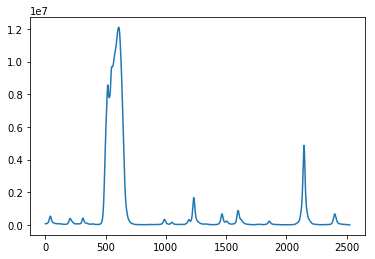

In [69]:
#Take cross-correlation of template with spectrum
ymatched = np.convolve(ymeas2,np.flip(ytemp, axis=0), 'same')
pl.plot(xvals2, ymatched)
pl.show()

In [70]:
#Use wavelet transform to find the peak positions
#add the beta because the peak on the matched filtered spectrum doesn't match the peak on the raw spectrum
#This is because of the skew. Adding on the skew decay constant seems to fix this offset
#The proof that this is mathematically sound is left as an exercise to the reader (i.e. this probably is wrong)
peak_pos = find_peaks_cwt(ymatched, widths = np.full(len(ymatched),sig)) + beta

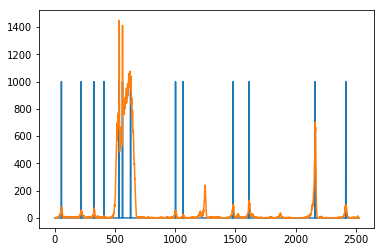

In [72]:
#plot this on a graph
#make array full of 0s that's the length of the spectrum. Want to change the peak positions to some value
#To show where the peak positions are on a graph
ypeaks = np.full(len(ymatched),0)

#loop over the x values and the peak positions to find where they match
for value in xvals2:
    for pos in peak_pos:
        #If there is a peak at a value of x, set the y value so you can see it on a graph 
        if value == pos + 0.5:
            ypeaks[int(pos)] = 1000

#plot out where the peaks are
pl.plot(xvals2, ypeaks)
pl.plot(xvals2, ymeas2)
pl.show()
